#Download dataset

##linux

In [ ]:
!rm -rf *
!git clone "https://github.com/hmda77/Ensemble-Indoor-Loc"
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Test-data.csv /content/
!cp /content/Ensemble-Indoor-Loc/JUIndoorLoc/JUIndoorLoc-Training-data.csv /content/
!rm -rf /content/Ensemble-Indoor-Loc/

rm: cannot remove 'drive/MyDrive': Operation canceled
rm: cannot remove 'drive/.shortcut-targets-by-id': Operation canceled
rm: cannot remove 'drive/.file-revisions-by-id': Operation canceled
rm: cannot remove 'drive/.Trash-0': Directory not empty
Cloning into 'Ensemble-Indoor-Loc'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 56 (delta 17), reused 5 (delta 1), pack-reused 0
Receiving objects: 100% (56/56), 695.75 KiB | 893.00 KiB/s, done.
Resolving deltas: 100% (17/17), done.


# windows

In [ ]:
!cd ./Desktop/Projects/ && git clone "https://github.com/hmda77/Ensemble-Indoor-Loc"
!cd ./Desktop/Projects/Ensemble-Indoor-Loc/


/bin/bash: line 1: cd: ./Desktop/Projects/: No such file or directory
/bin/bash: line 1: cd: ./Desktop/Projects/Ensemble-Indoor-Loc/: No such file or directory


# Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder , normalize
from itertools import cycle

import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from matplotlib import pyplot

# Metric Functions


In [2]:

# Make the confusion matrix
def confusion_plot(y_test,y_pred,title):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix {}".format(title))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    # report['Label']=[data_classes[i]  if i<5 else " " for i,x in enumerate(report.index)]
    report=report[['f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (5,4)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    # plt.title('ROC Curve for calss {0}'.format(data_classes[pos_label]))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,title):
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i],pos_label= i)
      plt.plot(fpr, tpr,lw=1)
    plt.plot([0 ,1],[0 ,1],'r')
    plt.title('ROC Curve for all classes in {}'.format(title))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # plt.legend(data_classes)
    plt.show()

#Dateset Proccesses

In [4]:
data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")
data_train.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_3844\1745947030.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_train = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Training-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-40-1,-84,-80,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870570949
1,L4-40-1,-84,-79,-71,-58,-110,-72,-71,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047205646
2,L4-40-1,-110,-110,-70,-56,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469870932338
3,L4-40-1,-110,-110,-70,-53,-110,-69,-68,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1470047629440
4,L4-37-2,-84,-82,-75,-65,-110,-73,-75,-110,-110,...,-110,-110,-110,-110,-110,-110,0,1,D4,1469876622694


In [5]:
data_train['Did'] = data_train['Did'].astype(str).str[1]
data_train['Did'] = pd.to_numeric(data_train['Did'])

In [6]:
data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")
data_test.head(5)

<>:1: SyntaxWarning: invalid escape sequence '\H'
<>:1: SyntaxWarning: invalid escape sequence '\H'
C:\Users\Hamid\AppData\Local\Temp\ipykernel_3844\2397508738.py:1: SyntaxWarning: invalid escape sequence '\H'
  data_test = pd.read_csv("C:\\Users\Hamid\content\JUIndoorLoc-Test-data.csv")


,Cid,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,AP167,AP168,AP169,AP170,AP171,AP172,Rs,Hpr,Did,Ts
0,L4-33-13,-77,-58,-66,-64,-92,-66,-66,-93,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813137748
1,L4-33-13,-90,-58,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813179138
2,L4-33-13,-80,-64,-78,-56,-92,-74,-74,-87,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812948443
3,L4-33-13,-72,-60,-74,-58,-93,-75,-76,-95,-93,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489812959103
4,L4-33-13,-82,-56,-74,-56,-93,-71,-76,-89,-110,...,-110,-110,-110,-110,-110,-110,0,0,D2,1489813079167


In [7]:
data_test['Did'] = data_test['Did'].astype(str).str[1]
data_test['Did'] = pd.to_numeric(data_test['Did'])

In [8]:
#make X_train from Tr
# X = normalize(data_train.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
X = data_train.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')]
y = data_train.Cid

# Xt = normalize(data_test.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')])
Xt = data_test.loc[:, (data_train.columns != 'Ts') & (data_train.columns != 'Cid')]
yt = data_test.Cid

le = LabelEncoder()
le.fit(y)
le.transform(y)


X_train = X
y_train_encode =  le.transform(y)

X_test = Xt
y_test_encode = le.transform(yt)

In [9]:
print(len(np.unique(y_train_encode)))
print(len(y.unique()))

991
991


# Adaboost Model (n_estimator = 50, depth=100)

In [10]:

base_estimator = DecisionTreeClassifier(max_depth=100)  # Shallow decision tree as a weak learner
n_estimators = 50  # Number of weak learners in the ensemble
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators)


# Fit the model
adaboost.fit(X_train, y_train_encode)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=100))

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

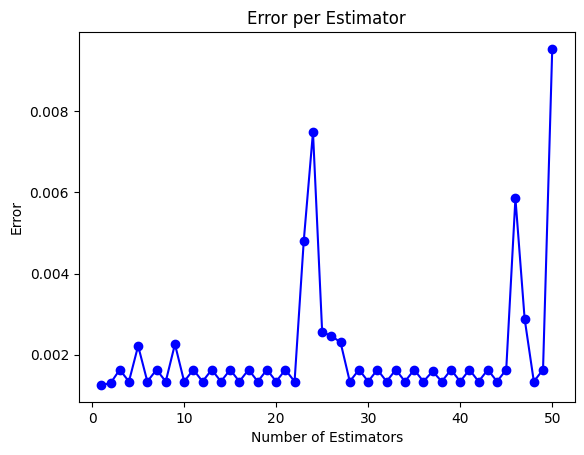

In [11]:
# Collect the error rate for each estimator
estimator_errors = []

for estimator in adaboost.estimators_:
    y_pred = estimator.predict(X_train)
    error = 1 - accuracy_score(y_train_encode, y_pred)
    estimator_errors.append(error)

# Plot the error for each estimator
plt.figure()
plt.plot(range(1, n_estimators + 1), estimator_errors, marker='o', linestyle='-', color='b')
plt.title('Error per Estimator')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.show()

In [12]:
y_pred_t = adaboost.predict(X)


In [13]:
accuracy = accuracy_score(y_train_encode, y_pred_t)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9987449799196787


In [14]:
y_pred = adaboost.predict(Xt)

In [15]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.963013698630137


In [16]:
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
417,0.000000,0.000000,0.000000,1.000000
584,0.000000,0.000000,0.000000,3.000000
630,1.000000,1.000000,1.000000,24.000000
631,1.000000,1.000000,1.000000,24.000000
632,0.956522,0.916667,1.000000,22.000000
633,1.000000,1.000000,1.000000,24.000000
634,1.000000,1.000000,1.000000,24.000000
635,1.000000,1.000000,1.000000,24.000000
636,1.000000,1.000000,1.000000,27.000000
638,1.000000,1.000000,1.000000,24.000000


In [17]:
base_estimator.fit(X,y_train_encode)

DecisionTreeClassifier(max_depth=100)

In [18]:
y_pred = base_estimator.predict(Xt)

In [19]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.897945205479452


# Adaboost Model (n_estimator = 500, maxdepth = 10)

In [ ]:

base_estimator = DecisionTreeClassifier(max_depth=10)  # Shallow decision tree as a weak learner
n_estimators = 500  # Number of weak learners in the ensemble
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators)


# Fit the model
adaboost.fit(X_train, y_train_encode)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                   n_estimators=500)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

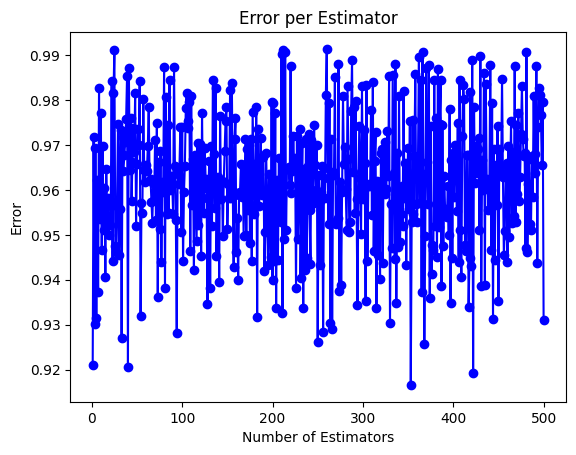

In [ ]:
# Collect the error rate for each estimator
estimator_errors = []

for estimator in adaboost.estimators_:
    y_pred = estimator.predict(X_train)
    error = 1 - accuracy_score(y_train_encode, y_pred)
    estimator_errors.append(error)

# Plot the error for each estimator
plt.figure()
plt.plot(range(1, n_estimators + 1), estimator_errors, marker='o', linestyle='-', color='b')
plt.title('Error per Estimator')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.show()

In [ ]:
y_pred_t = adaboost.predict(X)


In [ ]:
accuracy = accuracy_score(y_train_encode, y_pred_t)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4144912985274431


In [ ]:
y_pred = adaboost.predict(Xt)

In [ ]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9397260273972603


In [ ]:
generate_classification_report(y_test_encode, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1-score,precision,recall,support
375,0.000000,0.000000,0.000000,3.000000
526,0.000000,0.000000,0.000000,5.000000
584,0.000000,0.000000,0.000000,3.000000
630,1.000000,1.000000,1.000000,24.000000
631,1.000000,1.000000,1.000000,24.000000
632,0.956522,0.916667,1.000000,22.000000
633,1.000000,1.000000,1.000000,24.000000
634,1.000000,1.000000,1.000000,24.000000
635,1.000000,1.000000,1.000000,24.000000
636,0.920000,0.851852,1.000000,23.000000


In [ ]:
base_estimator.fit(X,y_train_encode)

DecisionTreeClassifier(max_depth=100)

In [ ]:
y_pred = base_estimator.predict(Xt)

In [ ]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9061643835616439


# Adaboost Model (n_estimator = ?, maxdepth = ?)

In [20]:

base_estimator = DecisionTreeClassifier(max_depth=50)  # Shallow decision tree as a weak learner
n_estimators = 100  # Number of weak learners in the ensemble
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators)


# Fit the model
adaboost.fit(X_train, y_train_encode)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=50),
                   n_estimators=100)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

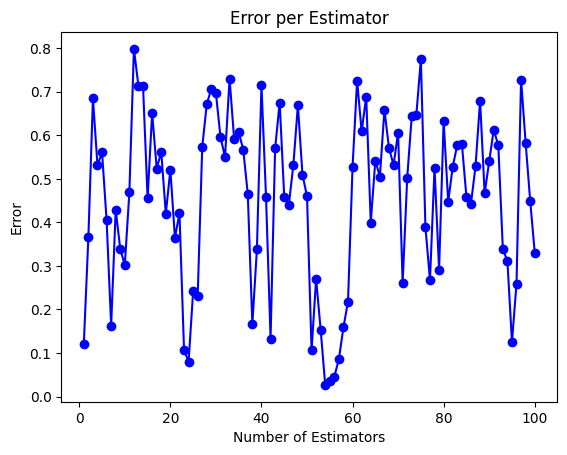

In [21]:
# Collect the error rate for each estimator
estimator_errors = []

for estimator in adaboost.estimators_:
    y_pred = estimator.predict(X_train)
    error = 1 - accuracy_score(y_train_encode, y_pred)
    estimator_errors.append(error)

# Plot the error for each estimator
plt.figure()
plt.plot(range(1, n_estimators + 1), estimator_errors, marker='o', linestyle='-', color='b')
plt.title('Error per Estimator')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.show()

In [22]:
y_pred_t = adaboost.predict(X)


In [23]:
accuracy = accuracy_score(y_train_encode, y_pred_t)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9987449799196787


In [24]:
y_pred = adaboost.predict(Xt)

In [25]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9972602739726028


In [26]:
generate_classification_report(y_test_encode, y_pred)

,f1-score,precision,recall,support
630,1.000000,1.000000,1.000000,24.00000
631,1.000000,1.000000,1.000000,24.00000
632,1.000000,1.000000,1.000000,24.00000
633,1.000000,1.000000,1.000000,24.00000
634,1.000000,1.000000,1.000000,24.00000
635,1.000000,1.000000,1.000000,24.00000
636,1.000000,1.000000,1.000000,27.00000
638,1.000000,1.000000,1.000000,24.00000
639,1.000000,1.000000,1.000000,24.00000
651,1.000000,1.000000,1.000000,32.00000


In [27]:
base_estimator.fit(X,y_train_encode)

DecisionTreeClassifier(max_depth=50)

In [28]:
y_pred = base_estimator.predict(Xt)

In [29]:
accuracy = accuracy_score(y_test_encode, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.863013698630137


# Adaboost with discrete SAMME and real SAMME.R
We now define the discrete and real AdaBoost classifiers
and fit them to the training set.

In [30]:
learning_rate = 1.0
n_estimators = 100

In [31]:
# Create an Dt depth = 1
dt_stump = DecisionTreeClassifier(max_depth=100, min_samples_leaf=1)
# Fit the model
dt_stump.fit(X_train, y_train_encode)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test_encode)

# Create an Dt depth = 9
dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
# Fit the model
dt.fit(X_train, y_train_encode)
dt_err = 1.0 - dt.score(X_test, y_test_encode)

In [32]:
# Create an AdaBoostClassifier
ada_discrete = AdaBoostClassifier(
    estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME",
)
# Fit the model
ada_discrete.fit(X_train, y_train_encode)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=100),
                   n_estimators=100)

In [33]:
# Create an AdaBoostClassifier
ada_real = AdaBoostClassifier(
    estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)
# Fit the model
ada_real.fit(X_train, y_train_encode)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=100),
                   n_estimators=100)

## Compute Test Error

In [34]:
from sklearn.metrics import zero_one_loss

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test_encode)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train_encode)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test_encode)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train_encode)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [35]:
# Make predictions on the test set
y_pred = ada_real.predict(X_test)
generate_classification_report(y_test_encode, y_pred)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
584,0.000000,0.000000,0.000000,3.000000
630,1.000000,1.000000,1.000000,24.000000
631,1.000000,1.000000,1.000000,24.000000
632,1.000000,1.000000,1.000000,24.000000
633,1.000000,1.000000,1.000000,24.000000
634,1.000000,1.000000,1.000000,24.000000
635,1.000000,1.000000,1.000000,24.000000
636,1.000000,1.000000,1.000000,27.000000
638,1.000000,1.000000,1.000000,24.000000
639,1.000000,1.000000,1.000000,24.000000


## plot the result

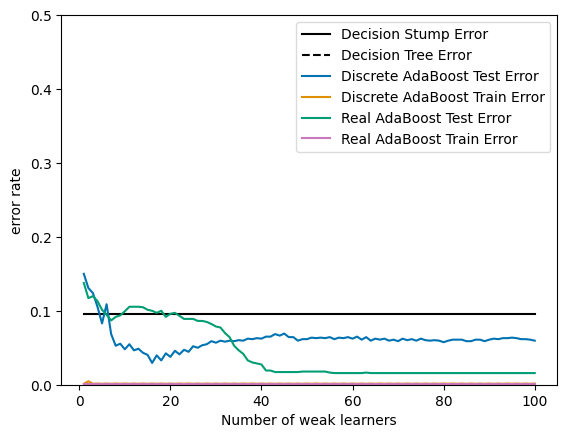

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, "k-", label="Decision Stump Error")
ax.plot([1, n_estimators], [dt_err] * 2, "k--", label="Decision Tree Error")

colors = sns.color_palette("colorblind")

ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err,
    label="Discrete AdaBoost Test Error",
    color=colors[0],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_discrete_err_train,
    label="Discrete AdaBoost Train Error",
    color=colors[1],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color=colors[2],
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color=colors[4],
)

ax.set_ylim((0.0, 0.5))
ax.set_xlabel("Number of weak learners")
ax.set_ylabel("error rate")

leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

# XGBoost Classification (default: max_depth=6)

In [ ]:
# model = XGBClassifier(device = "cuda", n_estimators = 100, max_depth = 3, subsample = 0.3, colsample_bytree=0.1, gamma = 100, eta=0.3)
# model = XGBClassifier(device = "cuda",  n_estimators = 1000, max_depth = 10, subsample = 0.5, colsample_bytree=0.001, eta=0.01)

model = XGBClassifier(device = "cuda")
eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

# #make model
# # c = KNeighborsClassifier(n_neighbors=5)
# c = XGBClassifier()
# # Prediction Y_pred
# define 10 Fold Cross Validation
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# y_pred = cross_val_predict(model, X_train, y_train_encode, cv=cv, n_jobs = 1, method = 'predict')

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.92855	validation_0-mlogloss:4.52954	validation_1-merror:0.87603	validation_1-mlogloss:3.83964
[1]	validation_0-merror:0.55731	validation_0-mlogloss:2.90224	validation_1-merror:0.56781	validation_1-mlogloss:2.54611
[2]	validation_0-merror:0.28669	validation_0-mlogloss:2.00710	validation_1-merror:0.34041	validation_1-mlogloss:1.91482
[3]	validation_0-merror:0.16365	validation_0-mlogloss:1.47243	validation_1-merror:0.26301	validation_1-mlogloss:1.60850
[4]	validation_0-merror:0.09940	validation_0-mlogloss:1.10464	validation_1-merror:0.22534	validation_1-mlogloss:1.40030
[5]	validation_0-merror:0.06275	validation_0-mlogloss:0.84694	validation_1-merror:0.21370	validation_1-mlogloss:1.25855
[6]	validation_0-merror:0.04045	validation_0-mlogloss:0.66136	validation_1-merror:0.20342	validation_1-mlogloss:1.13831
[7]	validation_0-merror:0.02636	validation_0-mlogloss:0.52437	validation_1-merror:0.18836	validation_1-mlogloss:1.03634
[8]	validation_0-merror:0.01832	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

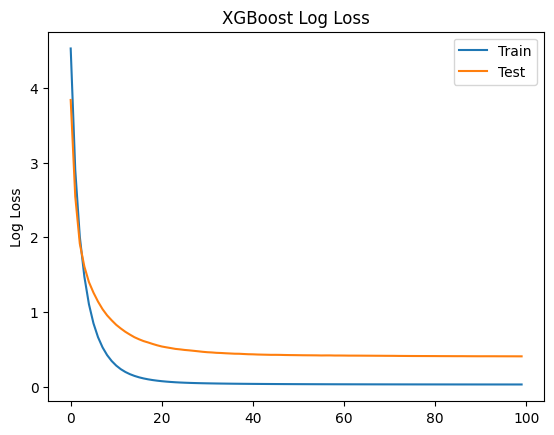

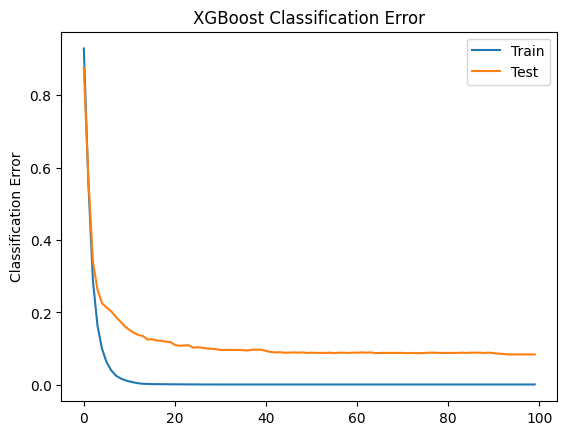

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
model = XGBClassifier(device = "cuda", n_estimators = 40)
eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

[0]	validation_0-merror:0.92855	validation_0-mlogloss:4.52954	validation_1-merror:0.87603	validation_1-mlogloss:3.83964
[1]	validation_0-merror:0.55731	validation_0-mlogloss:2.90224	validation_1-merror:0.56781	validation_1-mlogloss:2.54611
[2]	validation_0-merror:0.28669	validation_0-mlogloss:2.00710	validation_1-merror:0.34041	validation_1-mlogloss:1.91482
[3]	validation_0-merror:0.16365	validation_0-mlogloss:1.47243	validation_1-merror:0.26301	validation_1-mlogloss:1.60850
[4]	validation_0-merror:0.09940	validation_0-mlogloss:1.10464	validation_1-merror:0.22534	validation_1-mlogloss:1.40030
[5]	validation_0-merror:0.06275	validation_0-mlogloss:0.84694	validation_1-merror:0.21370	validation_1-mlogloss:1.25855
[6]	validation_0-merror:0.04045	validation_0-mlogloss:0.66136	validation_1-merror:0.20342	validation_1-mlogloss:1.13831
[7]	validation_0-merror:0.02636	validation_0-mlogloss:0.52437	validation_1-merror:0.18836	validation_1-mlogloss:1.03634
[8]	validation_0-merror:0.01832	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_encode = model.predict(X_test)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
generate_classification_report(y_test_encode, y_pred_encode)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
492,0.000000,0.000000,0.000000,4.00000
545,0.000000,0.000000,0.000000,3.00000
627,0.000000,0.000000,0.000000,1.00000
630,0.923077,1.000000,0.857143,28.00000
631,1.000000,1.000000,1.000000,24.00000
632,1.000000,1.000000,1.000000,24.00000
633,1.000000,1.000000,1.000000,24.00000
634,1.000000,1.000000,1.000000,24.00000
635,0.857143,0.750000,1.000000,18.00000
636,1.000000,1.000000,1.000000,27.00000


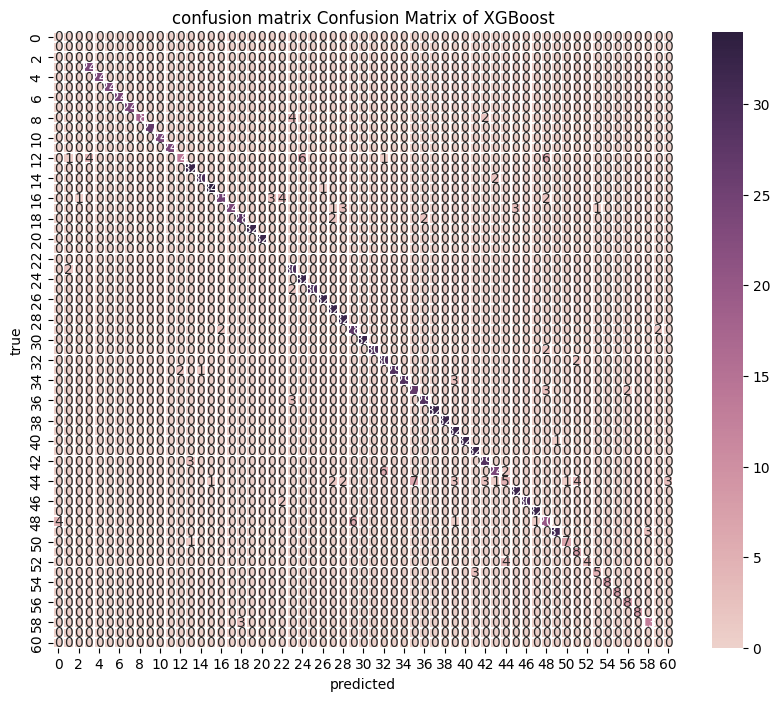

In [ ]:
confusion_plot(y_test_encode, y_pred_encode,"Confusion Matrix of XGBoost")

# XGBoost Classification (default: max_depth=50)

In [38]:
# model = XGBClassifier(device = "cuda", n_estimators = 100, max_depth = 3, subsample = 0.3, colsample_bytree=0.1, gamma = 100, eta=0.3)
# model = XGBClassifier(device = "cuda",  n_estimators = 1000, max_depth = 10, subsample = 0.5, colsample_bytree=0.001, eta=0.01)

model = XGBClassifier(device = "cuda", max_depth = 50)
eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

# #make model
# # c = KNeighborsClassifier(n_neighbors=5)
# c = XGBClassifier()
# # Prediction Y_pred
# define 10 Fold Cross Validation
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
# y_pred = cross_val_predict(model, X_train, y_train_encode, cv=cv, n_jobs = 1, method = 'predict')

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

[0]	validation_0-merror:0.92750	validation_0-mlogloss:4.62012	validation_1-merror:0.84795	validation_1-mlogloss:3.53963
[1]	validation_0-merror:0.57413	validation_0-mlogloss:3.04791	validation_1-merror:0.41507	validation_1-mlogloss:2.14282
[2]	validation_0-merror:0.31108	validation_0-mlogloss:2.12745	validation_1-merror:0.21233	validation_1-mlogloss:1.54124
[3]	validation_0-merror:0.17871	validation_0-mlogloss:1.57980	validation_1-merror:0.15479	validation_1-mlogloss:1.21551
[4]	validation_0-merror:0.10990	validation_0-mlogloss:1.19716	validation_1-merror:0.11096	validation_1-mlogloss:0.98807
[5]	validation_0-merror:0.07258	validation_0-mlogloss:0.92357	validation_1-merror:0.09795	validation_1-mlogloss:0.82595
[6]	validation_0-merror:0.04644	validation_0-mlogloss:0.72574	validation_1-merror:0.07603	validation_1-mlogloss:0.70240
[7]	validation_0-merror:0.03167	validation_0-mlogloss:0.57919	validation_1-merror:0.07055	validation_1-mlogloss:0.60321
[8]	validation_0-merror:0.02259	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

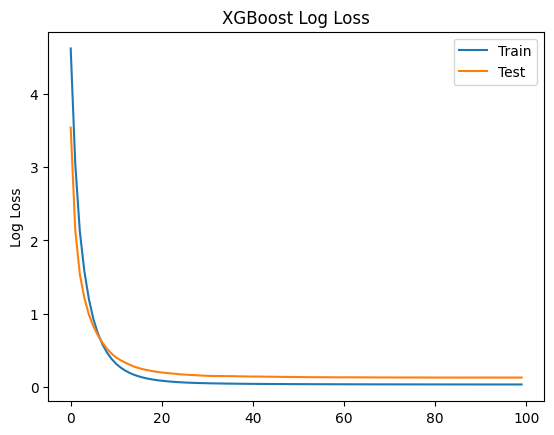

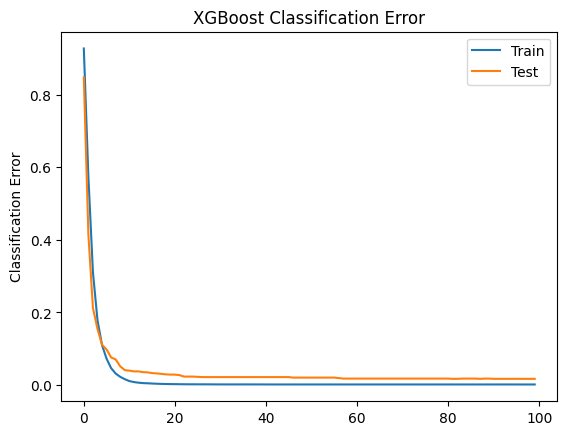

In [39]:
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [40]:
model = XGBClassifier(device = "cuda", n_estimators = 40)
eval_set = [(X_train, y_train_encode), (X_test, y_test_encode)]
model.fit(X_train, y_train_encode, early_stopping_rounds=10, eval_metric=["merror","mlogloss"], eval_set= eval_set, verbose=True)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

[0]	validation_0-merror:0.92750	validation_0-mlogloss:4.62012	validation_1-merror:0.84795	validation_1-mlogloss:3.53963
[1]	validation_0-merror:0.57446	validation_0-mlogloss:3.04883	validation_1-merror:0.42534	validation_1-mlogloss:2.14483
[2]	validation_0-merror:0.31187	validation_0-mlogloss:2.12940	validation_1-merror:0.22671	validation_1-mlogloss:1.54684
[3]	validation_0-merror:0.18122	validation_0-mlogloss:1.58571	validation_1-merror:0.15479	validation_1-mlogloss:1.22374
[4]	validation_0-merror:0.11216	validation_0-mlogloss:1.20540	validation_1-merror:0.11027	validation_1-mlogloss:0.99531
[5]	validation_0-merror:0.07375	validation_0-mlogloss:0.93446	validation_1-merror:0.09589	validation_1-mlogloss:0.83053
[6]	validation_0-merror:0.04815	validation_0-mlogloss:0.73862	validation_1-merror:0.07329	validation_1-mlogloss:0.70600
[7]	validation_0-merror:0.03393	validation_0-mlogloss:0.59266	validation_1-merror:0.07123	validation_1-mlogloss:0.60510
[8]	validation_0-merror:0.02464	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
y_pred_encode = model.predict(X_test)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

In [42]:
generate_classification_report(y_test_encode, y_pred_encode)

C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hamid\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,f1-score,precision,recall,support
630,1.000000,1.000000,1.000000,24.000000
631,1.000000,1.000000,1.000000,24.000000
632,1.000000,1.000000,1.000000,24.000000
633,1.000000,1.000000,1.000000,24.000000
634,1.000000,1.000000,1.000000,24.000000
635,1.000000,1.000000,1.000000,24.000000
636,1.000000,1.000000,1.000000,27.000000
638,1.000000,1.000000,1.000000,24.000000
639,1.000000,1.000000,1.000000,24.000000
651,0.941176,1.000000,0.888889,36.000000


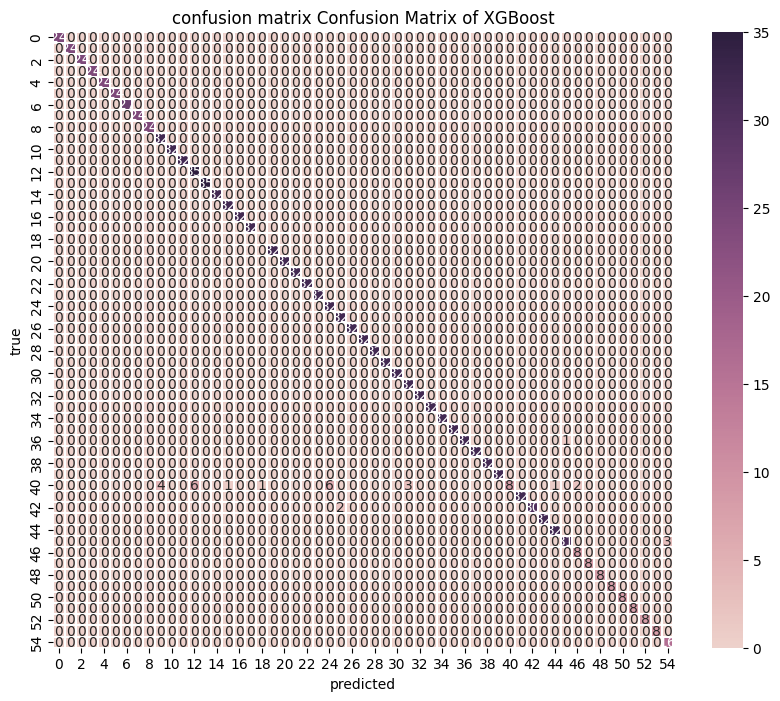

In [43]:
confusion_plot(y_test_encode, y_pred_encode,"Confusion Matrix of XGBoost")